# Predict all cause 30-day hospital readmission risk

### Importing the required libraries

In [1]:
!pip install pyarrow

    100% |████████████████████████████████| 60.1MB 816kB/s eta 0:00:01
You are using pip version 10.0.1, however version 19.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Importing libs into the python environment. These functions will be referenced later in the notebook code.

from __future__ import print_function
import os
import pandas as pd
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import s3fs
import pyarrow.parquet as pq
from pyarrow.filesystem import S3FSWrapper


from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# Put this when it's called
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report


# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data*100

# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")
    plt.legend(loc="best")
    return plt


# Plot validation curve
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, cv)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    plt.grid() 
    plt.xscale('log')
    plt.legend(loc='best') 
    plt.xlabel('Parameter') 
    plt.ylabel('Score') 
    plt.ylim(ylim)
    
    
# Read single parquet file from S3
def pd_read_s3_parquet(key, bucket, s3_client=None, **args):
    if s3_client is None:
        s3_client = boto3.client('s3')
    obj = s3_client.get_object(Bucket=bucket, Key=key)
    pf = ParquetFile('myfile.parq')
    return pd.read_parquet(io.BytesIO(obj['Body'].read()), **args)

# Read multiple parquets from a folder on S3 generated by spark
def pd_read_s3_multiple_parquets(filepath, bucket, s3=None, 
                                 s3_client=None, verbose=False, **args):
    if not filepath.endswith('/'):
        filepath = filepath + '/'  # Add '/' to the end
    if s3_client is None:
        s3_client = boto3.client('s3')
    if s3 is None:
        s3 = boto3.resource('s3')
    s3_keys = [item.key for item in s3.Bucket(bucket).objects.filter(Prefix=filepath)
               if item.key.endswith('.parquet')]
    if not s3_keys:
        print('No parquet found in', bucket, filepath)
    elif verbose:
        print('Load parquets:')
        for p in s3_keys: 
            print(p)
    dfs = [pd_read_s3_parquet(key, bucket=bucket, s3_client=s3_client, **args) 
           for key in s3_keys]
    return pd.concat(dfs, ignore_index=True)

# Thinking about Data

It is important to understand the relationship between different tables and the data in those tables. This is important to identify the information which is relevant to the prediction. Here is the schema.

## Cleaning and Visualizing Your Data

<img src="EHR.png">

In [3]:
import boto3
import botocore 
import io
bucket = 'readmission-data' # Update this to the bucket that was created in your lab account as part of this enviroment.
prefix = "train_data/parquet"
 
s3 = boto3.resource('s3')

Raw data files are in an S3 bucket in your AWS lab account. Twelve tables will be used (allergies, careplans, conditions,encounters, imaging-studies,immunizations, medications,observations, organizations, procedures, providers). Raw comma-separated value files will be downloaded into your Amazon Sagemaker instance, and imported into a DataFrame, where it's easier to work with the structured data. Raw files do not contain row headers, and thus labels are being assiged at import.

In [4]:
##df_first_merge = pd_read_s3_multiple_parquets(prefix, bucket)
import s3fs
import pyarrow.parquet as pq
from pyarrow.filesystem import S3FSWrapper

fs = s3fs.S3FileSystem()


# Python 3.6 or later
p_dataset = pq.ParquetDataset(
    f"s3://{bucket}/{prefix}",
    filesystem=fs
)
df_first_merge = p_dataset.read().to_pandas()

df_first_merge.head()


,encounters_reasoncode,patient_healthcare_expenses,encounters_encounterclass,encounters_id,patient_gender,patient_healthcare_coverage,patient_marital,encounters_total_claim_cost,patient_ethnicity,patient_id,...,encounters_payer,procedures_code,procedures_base_cost,medications_base_cost,medications_totalcost,organizations_id,organizations_revenue,providers_speciality,providers_state,providers_utilization
0,0,449794.0,wellness,8204f002-9d2a-484b-a7f5-168fa531acfa,M,3283.92,,129.16,chinese,6cae0ba8-1985-49ea-8441-4c738f7e9493,...,4d71f845-a6a9-3c39-b242-14d25ef86a8d,4.281910e+14,898.76,NaN,NaN,006af5b6-7c9e-3532-9135-21d07a279c27,3487.32,M,MA,0.0
1,0,449794.0,wellness,8204f002-9d2a-484b-a7f5-168fa531acfa,M,3283.92,,129.16,chinese,6cae0ba8-1985-49ea-8441-4c738f7e9493,...,4d71f845-a6a9-3c39-b242-14d25ef86a8d,4.281910e+14,898.76,NaN,NaN,006af5b6-7c9e-3532-9135-21d07a279c27,3487.32,F,MA,0.0
2,0,449794.0,wellness,8204f002-9d2a-484b-a7f5-168fa531acfa,M,3283.92,,129.16,chinese,6cae0ba8-1985-49ea-8441-4c738f7e9493,...,4d71f845-a6a9-3c39-b242-14d25ef86a8d,4.281910e+14,898.76,NaN,NaN,006af5b6-7c9e-3532-9135-21d07a279c27,3487.32,M,MA,27.0
3,0,449794.0,wellness,8204f002-9d2a-484b-a7f5-168fa531acfa,M,3283.92,,129.16,chinese,6cae0ba8-1985-49ea-8441-4c738f7e9493,...,4d71f845-a6a9-3c39-b242-14d25ef86a8d,4.281910e+14,898.76,NaN,NaN,006af5b6-7c9e-3532-9135-21d07a279c27,3487.32,M,MA,0.0
4,0,449794.0,wellness,8204f002-9d2a-484b-a7f5-168fa531acfa,M,3283.92,,129.16,chinese,6cae0ba8-1985-49ea-8441-4c738f7e9493,...,4d71f845-a6a9-3c39-b242-14d25ef86a8d,4.281910e+14,898.76,NaN,NaN,006af5b6-7c9e-3532-9135-21d07a279c27,3487.32,F,MA,0.0


Assumption: Taking the data in which encounter class is inpatient. For all other encounter class, patient is assumed to not be admitted in the hospital.
Data preparation for cleaning and augmentation.
Identifying the duration of Patient Admission

In [5]:
draw_missing_data_table(df_first_merge)


,Total,Percent
medications_totalcost,3679740100,86.669703
medications_base_cost,3679740100,86.669703
procedures_code,2047961800,48.236081
procedures_base_cost,2043039400,48.120143
providers_state,117500,0.002768
providers_utilization,117500,0.002768
organizations_id,117500,0.002768
organizations_revenue,117500,0.002768
providers_speciality,117500,0.002768
patient_ethnicity,0,0.000000


In [6]:
#df_first_merge = df_first_merge[df_first_merge['encounters_encounterclass'] == 'inpatient'] 
## Selecting data - Ignoring wellness (since patient not admitted)
df_first_merge = df_first_merge[df_first_merge['encounters_encounterclass'].isin(['inpatient','ambulatory','urgentcare','outpatient','emergency'])] 
df_first_merge["encounters_stop"] = pd.to_datetime(df_first_merge["encounters_stop"]).dt.tz_localize(None)
df_first_merge["encounters_start"] = pd.to_datetime(df_first_merge["encounters_start"]).dt.tz_localize(None)
df_first_merge["admission_duration"] = df_first_merge['encounters_stop'] - df_first_merge['encounters_start']
df_first_merge.head()

,encounters_reasoncode,patient_healthcare_expenses,encounters_encounterclass,encounters_id,patient_gender,patient_healthcare_coverage,patient_marital,encounters_total_claim_cost,patient_ethnicity,patient_id,...,procedures_code,procedures_base_cost,medications_base_cost,medications_totalcost,organizations_id,organizations_revenue,providers_speciality,providers_state,providers_utilization,admission_duration
113,88805009,1340788.37,ambulatory,0103e59e-a95f-4cd3-8736-6dfb669cb681,F,24064.03,M,129.16,irish,122867be-18b4-448c-a5a2-40ebc27d0ac8,...,NaN,NaN,NaN,NaN,03347b4d-994e-302b-848b-58019a4e274d,2.068366e+06,F,MA,48546.0,00:15:00
114,88805009,1340788.37,ambulatory,0103e59e-a95f-4cd3-8736-6dfb669cb681,F,24064.03,M,129.16,irish,122867be-18b4-448c-a5a2-40ebc27d0ac8,...,NaN,NaN,NaN,NaN,03347b4d-994e-302b-848b-58019a4e274d,2.068366e+06,F,MA,16462.0,00:15:00
115,88805009,1340788.37,ambulatory,0103e59e-a95f-4cd3-8736-6dfb669cb681,F,24064.03,M,129.16,irish,122867be-18b4-448c-a5a2-40ebc27d0ac8,...,NaN,NaN,NaN,NaN,03347b4d-994e-302b-848b-58019a4e274d,6.120915e+06,F,MA,48546.0,00:15:00
116,88805009,1340788.37,ambulatory,0103e59e-a95f-4cd3-8736-6dfb669cb681,F,24064.03,M,129.16,irish,122867be-18b4-448c-a5a2-40ebc27d0ac8,...,NaN,NaN,NaN,NaN,03347b4d-994e-302b-848b-58019a4e274d,6.120915e+06,F,MA,16462.0,00:15:00
117,72892002,723145.37,ambulatory,01b0068e-e898-4884-b88b-867868f1ed76,F,7423.03,M,129.16,puerto_rican,cbb13e11-10b9-44fd-a7bf-07a7cc7b4c13,...,274804006.0,6021.33,NaN,NaN,03347b4d-994e-302b-848b-58019a4e274d,2.068366e+06,F,MA,48546.0,00:45:00


Merging Immuninzations and Encounters to single data set based on Encounter ID since there are encounters for which there was no immunization administered. Left Join to take existing data merged with Immunization data. 

Identify missing values in the data set. 

In [7]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
df_first_merge.head(5)


,encounters_reasoncode,patient_healthcare_expenses,encounters_encounterclass,encounters_id,patient_gender,patient_healthcare_coverage,patient_marital,encounters_total_claim_cost,patient_ethnicity,patient_id,encounters_code,encounters_payer_coverage,encounters_stop,encounters_base_encounter_cost,patient_race,patient_birthdate,encounters_start,encounters_payer,procedures_code,procedures_base_cost,medications_base_cost,medications_totalcost,organizations_id,organizations_revenue,providers_speciality,providers_state,providers_utilization,admission_duration
113,88805009,1340788.37,ambulatory,0103e59e-a95f-4cd3-8736-6dfb669cb681,F,24064.03,M,129.16,irish,122867be-18b4-448c-a5a2-40ebc27d0ac8,185347001,89.16,2002-09-23 20:58:42,129.16,white,1917-09-25,2002-09-23 20:43:42,7caa7254-5050-3b5e-9eae-bd5ea30e809c,NaN,NaN,NaN,NaN,03347b4d-994e-302b-848b-58019a4e274d,2.068366e+06,F,MA,48546.0,00:15:00
114,88805009,1340788.37,ambulatory,0103e59e-a95f-4cd3-8736-6dfb669cb681,F,24064.03,M,129.16,irish,122867be-18b4-448c-a5a2-40ebc27d0ac8,185347001,89.16,2002-09-23 20:58:42,129.16,white,1917-09-25,2002-09-23 20:43:42,7caa7254-5050-3b5e-9eae-bd5ea30e809c,NaN,NaN,NaN,NaN,03347b4d-994e-302b-848b-58019a4e274d,2.068366e+06,F,MA,16462.0,00:15:00
115,88805009,1340788.37,ambulatory,0103e59e-a95f-4cd3-8736-6dfb669cb681,F,24064.03,M,129.16,irish,122867be-18b4-448c-a5a2-40ebc27d0ac8,185347001,89.16,2002-09-23 20:58:42,129.16,white,1917-09-25,2002-09-23 20:43:42,7caa7254-5050-3b5e-9eae-bd5ea30e809c,NaN,NaN,NaN,NaN,03347b4d-994e-302b-848b-58019a4e274d,6.120915e+06,F,MA,48546.0,00:15:00
116,88805009,1340788.37,ambulatory,0103e59e-a95f-4cd3-8736-6dfb669cb681,F,24064.03,M,129.16,irish,122867be-18b4-448c-a5a2-40ebc27d0ac8,185347001,89.16,2002-09-23 20:58:42,129.16,white,1917-09-25,2002-09-23 20:43:42,7caa7254-5050-3b5e-9eae-bd5ea30e809c,NaN,NaN,NaN,NaN,03347b4d-994e-302b-848b-58019a4e274d,6.120915e+06,F,MA,16462.0,00:15:00
117,72892002,723145.37,ambulatory,01b0068e-e898-4884-b88b-867868f1ed76,F,7423.03,M,129.16,puerto_rican,cbb13e11-10b9-44fd-a7bf-07a7cc7b4c13,424619006,69.16,2013-10-09 16:19:05,129.16,hispanic,1986-06-25,2013-10-09 15:34:05,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,274804006.0,6021.33,NaN,NaN,03347b4d-994e-302b-848b-58019a4e274d,2.068366e+06,F,MA,48546.0,00:45:00


In [8]:
draw_missing_data_table(df_first_merge)

,Total,Percent
medications_totalcost,1110685500,72.616197
medications_base_cost,1110685500,72.616197
procedures_code,531188700,34.728916
procedures_base_cost,526266300,34.407091
admission_duration,0,0.000000
encounters_payer_coverage,0,0.000000
patient_healthcare_expenses,0,0.000000
encounters_encounterclass,0,0.000000
encounters_id,0,0.000000
patient_gender,0,0.000000


In [9]:
# Fill missing values
## Imputation of missing data 
marital_status = 'NM'
df_first_merge['patient_marital'] = df_first_merge['patient_marital'].fillna(marital_status, inplace=False)

## There are entries in which procedures_code is missing, reason could be that no procedures were performed 
## so setting the value as zero for those outliers 
df_first_merge['procedures_code'] = df_first_merge['procedures_code'].fillna(0, inplace=False)

## Setting the procedures base cost to zero since there was no procedure performed and no charge shown
df_first_merge['procedures_base_cost'] = df_first_merge['procedures_base_cost'].fillna(0, inplace=False) 

## Due to low missing values for Patient ZIP, deleting those rows
draw_missing_data_table(df_first_merge)



,Total,Percent
medications_totalcost,1110685500,72.616197
medications_base_cost,1110685500,72.616197
admission_duration,0,0.000000
encounters_stop,0,0.000000
patient_healthcare_expenses,0,0.000000
encounters_encounterclass,0,0.000000
encounters_id,0,0.000000
patient_gender,0,0.000000
patient_healthcare_coverage,0,0.000000
patient_marital,0,0.000000


In [10]:
## Sorting the data by Patient Id and Encounter Start Date so that we can calculate readmission within x number of days. 
##After looking at the data, it was found that there are multiple entries for encounter on the same start date so adding 
## encounter stop date to the sort
df_first_merge = df_first_merge.sort_values(by=['patient_id', 'encounters_start', 'encounters_stop'])
df_first_merge.describe(include='all')
df_first_merge.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15295286 entries, 37328709 to 31792030
Data columns (total 28 columns):
encounters_reasoncode             int64
patient_healthcare_expenses       float64
encounters_encounterclass         object
encounters_id                     object
patient_gender                    object
patient_healthcare_coverage       float64
patient_marital                   object
encounters_total_claim_cost       float64
patient_ethnicity                 object
patient_id                        object
encounters_code                   int64
encounters_payer_coverage         float64
encounters_stop                   datetime64[ns]
encounters_base_encounter_cost    float64
patient_race                      object
patient_birthdate                 object
encounters_start                  datetime64[ns]
encounters_payer                  object
procedures_code                   float64
procedures_base_cost              float64
medications_base_cost             flo

In [11]:
df_first_merge['readmission_hrs'] = np.where((df_first_merge['patient_id'].shift(axis=0,periods=-1) == df_first_merge['patient_id']),(df_first_merge['encounters_start'].shift(axis=0,periods=-1) - df_first_merge['encounters_stop']).astype('timedelta64[h]'),0)
## Shift the values of READMISSION by 1 row down
df_first_merge['readmission_hrs'] = df_first_merge.apply(lambda x: df_first_merge['readmission_hrs'].shift(1))
## Verifying data 
df_first_merge.head(10)

## Convert ADMISSION DURATION into hours for model fitting
td = df_first_merge['admission_duration']
df_first_merge['admission_duration_hrs'] = td / pd.Timedelta('1 hour')

df_first_merge.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15295286 entries, 37328709 to 31792030
Data columns (total 30 columns):
encounters_reasoncode             int64
patient_healthcare_expenses       float64
encounters_encounterclass         object
encounters_id                     object
patient_gender                    object
patient_healthcare_coverage       float64
patient_marital                   object
encounters_total_claim_cost       float64
patient_ethnicity                 object
patient_id                        object
encounters_code                   int64
encounters_payer_coverage         float64
encounters_stop                   datetime64[ns]
encounters_base_encounter_cost    float64
patient_race                      object
patient_birthdate                 object
encounters_start                  datetime64[ns]
encounters_payer                  object
procedures_code                   float64
procedures_base_cost              float64
medications_base_cost             flo

In [12]:
## Droppig rows which have nan in readmission_hrs column
df_first_merge=df_first_merge.dropna(subset=['readmission_hrs'])
## Identifying null values for readmission columns to validate calculation
readmission_hrs_nv = pd.isnull(df_first_merge["readmission_hrs"])
df_first_merge[readmission_hrs_nv]


,encounters_reasoncode,patient_healthcare_expenses,encounters_encounterclass,encounters_id,patient_gender,patient_healthcare_coverage,patient_marital,encounters_total_claim_cost,patient_ethnicity,patient_id,encounters_code,encounters_payer_coverage,encounters_stop,encounters_base_encounter_cost,patient_race,patient_birthdate,encounters_start,encounters_payer,procedures_code,procedures_base_cost,medications_base_cost,medications_totalcost,organizations_id,organizations_revenue,providers_speciality,providers_state,providers_utilization,admission_duration,readmission_hrs,admission_duration_hrs


In [13]:
## Need to replace the negatives values with 0
## Creating the label 'READMISSION' based on READMISSION criteria which is 30 days i.e. 720 hours
## Readmission = 1 (true) if READMISSION_HRS < 720
df_first_merge['readmission'] = np.where(((df_first_merge['readmission_hrs'] > 0) & (df_first_merge['readmission_hrs'] < 720)) ,1,0)
##draw_missing_data_table(df_third_merge)


In [14]:
# check whether readmission occured for any medication encounters or not
#df_first_merge[(df_first_merge['medications_totalcost'].isnull()) 
#               & (df_first_merge['readmission'] == 1)]
               


In [15]:
# check whether readmission occured for any medication encounters or not
#df_first_merge[(df_first_merge['medications_totalcost'].notnull()) 
#               & (df_first_merge['readmission'] == 1)]

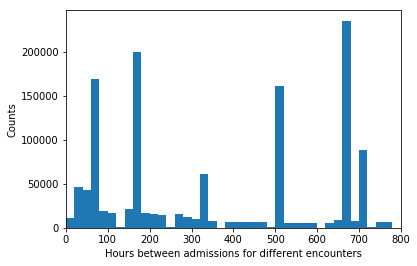

In [16]:
# plot a histogram of days between readmissions if they exist
# this only works for non-null values so you have to filter
import matplotlib
import matplotlib.pyplot as plt
plt.hist(df_first_merge.loc[(df_first_merge['readmission_hrs'].notnull()) & 
                            (df_first_merge['readmission_hrs'] > 0),'readmission_hrs'], bins =range(0,800,20))
plt.xlim([0,800])
plt.xlabel('Hours between admissions for different encounters')
plt.ylabel('Counts')
plt.show()





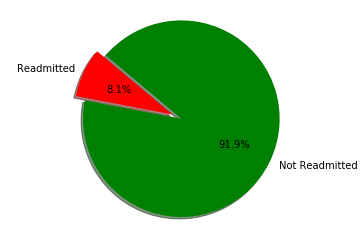

In [17]:
import matplotlib.pyplot as plt

# Data to plot
labels = 'Readmitted', 'Not Readmitted'
sizes = [(df_first_merge.readmission == 1).sum(), (df_first_merge.readmission == 0).sum()]
colors = ['red', 'green']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [18]:
## Preparing Label Data i.e. Readmission 
print('Precent of positive samples:', (((df_first_merge.readmission == 1).sum())/len(df_first_merge)*100))
print('Percent of negative samples:',  (((df_first_merge.readmission == 0).sum())/len(df_first_merge)*100))
print('Total samples:',len(df_first_merge))

Precent of positive samples: 8.11877647261885
Percent of negative samples: 91.88122352738115
Total samples: 15295285


In [19]:
df_first_merge['patient_birthdate']= pd.to_datetime(df_first_merge['patient_birthdate'])


In [ ]:
from datetime import datetime
from datetime import date
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))
## Convert BIRTH DATE INTO AGE factor
df_first_merge['age'] = df_first_merge['patient_birthdate'].apply(calculate_age)
draw_missing_data_table(df_first_merge)


,Total,Percent
medications_base_cost,1110685400,72.616195
medications_totalcost,1110685400,72.616195
age,0,0.000000
patient_ethnicity,0,0.000000
encounters_stop,0,0.000000
encounters_payer_coverage,0,0.000000
encounters_code,0,0.000000
patient_id,0,0.000000
encounters_total_claim_cost,0,0.000000
patient_race,0,0.000000


In [ ]:
## Dropping the columns which are not required to do feature selection
df_first_merge=df_first_merge.drop(columns=['admission_duration','medications_totalcost','medications_base_cost',
                                          'patient_birthdate','encounters_id','patient_id','organizations_id',
                                         'encounters_start','encounters_stop','admission_duration_hrs',
                                            'encounters_payer','readmission_hrs'])

## Dropping READMISSION_HRS since it affects the model negatively and takes away the importance of all other features
#df_ft_select=df_ft_select.drop(columns=['readmission_hrs'])
df_first_merge.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15295285 entries, 37328710 to 31792030
Data columns (total 20 columns):
encounters_reasoncode             int64
patient_healthcare_expenses       float64
encounters_encounterclass         object
patient_gender                    object
patient_healthcare_coverage       float64
patient_marital                   object
encounters_total_claim_cost       float64
patient_ethnicity                 object
encounters_code                   int64
encounters_payer_coverage         float64
encounters_base_encounter_cost    float64
patient_race                      object
procedures_code                   float64
procedures_base_cost              float64
organizations_revenue             float64
providers_speciality              object
providers_state                   object
providers_utilization             float64
readmission                       int64
age                               int64
dtypes: float64(9), int64(4), object(7)
memory usage:

In [ ]:
## Identifying categorical variables in the data set i.e. enumerated values for variables such as Gender, Organization State,Encounter Class, Encounter Code, Encounter Cost, Marital Status
### We are identifying unique values for a column, if unique values are less than 25 we consider it as categorical variable
df_first_merge['encounters_encounterclass'] = pd.Categorical(df_first_merge['encounters_encounterclass'])
df_first_merge['patient_gender'] = pd.Categorical(df_first_merge['patient_gender'])
df_first_merge['patient_marital'] = pd.Categorical(df_first_merge['patient_marital'])
df_first_merge['patient_ethnicity'] = pd.Categorical(df_first_merge['patient_ethnicity'])
df_first_merge['patient_race'] = pd.Categorical(df_first_merge['patient_race'])
df_first_merge['providers_speciality'] = pd.Categorical(df_first_merge['providers_speciality'])
df_first_merge['providers_state'] = pd.Categorical(df_first_merge['providers_state'])
df_first_merge['encounters_reasoncode'] = pd.Categorical(df_first_merge['encounters_reasoncode'])
df_first_merge['encounters_code'] = pd.Categorical(df_first_merge['encounters_code'])
df_first_merge['procedures_code'] = pd.Categorical(df_first_merge['procedures_code'])


# Transform categorical variables into dummy variables
df_first_merge = pd.get_dummies(df_first_merge, drop_first=True)  # To avoid dummy trap



The resulted DataFrame is serialized and written to a flat file called the Pickle using the **Pickle** library. This file is then saved into the Amazon S3 bucket for later re-use of the data. You can generate a Pickle file using `pickle.dump` and save the raw datafile in that object and upload the file to the lab S3 bucket.

In [ ]:
## As a next step, we can use trusted pickle to check for signature on pickle dump when it is read to avoid spoofing
import pickle
with open('readmission-processed-data.pkl', 'wb') as handle:
    pickle.dump(df_first_merge, handle, protocol=pickle.HIGHEST_PROTOCOL)
s3.Bucket(bucket).upload_file('readmission-processed-data.pkl','processed-data/readmission-processed-data.pkl',ExtraArgs={"ServerSideEncryption": "aws:kms","SSEKMSKeyId":"3a90a5d2-2ba8-4942-b9df-9a27ff7bf412" })
